In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## 1. Data Downloading and Transformation

In [2]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('../data/Catch Me If You Can/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../data/Catch Me If You Can/test_sessions.csv',
                      index_col='session_id')

# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"../data/Catch Me If You Can/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head(20)

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu
37491,img378.imageshack.us
5462,ecologie.nature.free.fr
35425,www.ibcn.intec.ugent.be
30151,kissanime.com
38268,www.carolineconduiteformation.com


### 4.1. What are the dimensions of the training and test sets (in exactly this order)?

In [4]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

### Answer(4.1): (253561, 21) and (82797, 20) 

## 2. Brief Exploratory Data Analysis

Before we start training models, we have to perform Exploratory Data Analysis (EDA). Today, we are going to perform a shorter version, but we will use other techniques as we move forward. Let's check which websites in the training data set are the most visited. As you can see, they are Google services and a bioinformatics website (a website with 'zero'-index is our missed values, just ignore it):


In [4]:
train_df[sites].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(20)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
812     35178
80      31391
570     30616
55      27812
39      25275
37      23726
30      23495
786     23026
35      22470
76      20922
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


### 4.2. What kind of websites does Alice visit the most?

In [6]:
Alice_sessions = train_df[train_df['target']==1]

In [7]:
Alice_sessions[sites].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
251175,270,270,270,21,21,7832,21,7832,30,7832
196388,29,7832,37,7832,7832,29,7832,29,7832,7832
172448,29,7832,7832,29,37,7832,29,7832,29,270
70129,167,167,1515,167,37,1514,855,1515,855,1514
206254,1520,1522,1522,1515,1515,1524,1514,1515,1520,1521


In [8]:
# Top websites in the training data set
top_sites_Alice = pd.Series(Alice_sessions[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(20)
print(top_sites_Alice)
sites_dict.loc[top_sites_Alice.index]

77      1382
80      1354
76      1307
29       897
21       857
81       609
879      522
22       522
75       451
82       447
23       437
35       381
881      371
37       293
33       291
3000     286
733      274
30       272
78       236
941      215
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


### Answer(4.2): videohostings 

Now let us look at the timestamps and try to characterize sessions as timeframes:

In [9]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In order to perform the next task, generate descriptive statistics as you did in the first assignment.

### 4.3. Select all correct statements:

on average, Alice's session is shorter than that of other users?
**-True**

In [10]:
#for Alice
time_df[time_df['target']==1]['seconds'].mean()

52.29647366129734

In [11]:
#for another
time_df[time_df['target']==0]['seconds'].mean()

139.28237232552215

more than 1% of all sessions in the dataset belong to Alice?
**-False**

In [12]:
procents = 100*(time_df[time_df['target']==1]['target'].count()/time_df.shape[0])
print('Alice sessions of all: ',procents, '%')

Alice sessions of all:  0.905896411514389 %


minimum and maximum durations of Alice's and other users' sessions are approximately the same?
**-True**

In [13]:
#for Alice
min_duration = time_df[time_df['target']==1]['seconds'].min()
max_duration = time_df[time_df['target']==1]['seconds'].max()
print('minimum duration for Alice:%ds' % min_duration,'\nmaximum duration for Alice:%ds' % max_duration)

minimum duration for Alice:0s 
maximum duration for Alice:1763s


In [14]:
#for another
min_duration_an = time_df[time_df['target']==0]['seconds'].min()
max_duration_an = time_df[time_df['target']==0]['seconds'].max()
print('minimum duration for another:%ds' % min_duration_an,'\nmaximum duration for another:%ds' % max_duration_an)

minimum duration for another:0s 
maximum duration for another:1800s


variation about the mean session duration for all users (including Alice) is approximately the same?
**-False**

In [15]:
time_df[time_df['target']==1]['seconds'].std()

153.30901405274358

In [16]:
time_df[time_df['target']==0]['seconds'].std()

296.6535177185032

In [93]:
#time_df[time_df['target']==0].describe()

In [92]:
#time_df.describe()

less than a quarter of Alice's sessions are greater than or equal to 40 seconds?
**-True**

In [17]:
Alice_time_df = time_df[time_df['target']==1]

In [18]:
Alice_time_df.quantile(0.7591464)

target      1.0
seconds    40.0
Name: 0.7591464, dtype: float64

In [19]:
Alice_time_df.describe()

,target,seconds
count,2297.0,2297.000000
mean,1.0,52.296474
std,0.0,153.309014
min,1.0,0.000000
25%,1.0,4.000000
50%,1.0,11.000000
75%,1.0,38.000000
max,1.0,1763.000000


In [20]:
Quant = Alice_time_df['seconds'].quantile(.75)
Quant1 = Alice_time_df['seconds'].quantile(1)

Alice_time_df[Alice_time_df['seconds'].between(Quant, Quant1)][['seconds']].min()

seconds    38.0
dtype: float64

In order to train our first model, we need to prepare the data. First of all, exclude the target variable from the training set. Now both training and test sets have the same number of columns, therefore aggregate them into one dataframe. Thus, all transformations will be performed simultaneously on both training and test data sets.

In [21]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [22]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [25]:
sites_flatten

array([  56,   55,    0, ..., 1098, 1098, 1098], dtype=uint16)

In [24]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [26]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


In [27]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
small_example = csr_matrix((data, indices, indptr))[:, 1:]

In [28]:
small_example

<3x4 sparse matrix of type '<class 'numpy.int32'>'
	with 7 stored elements in Compressed Sparse Row format>

In [29]:
small_example.todense()

matrix([[1, 0, 0, 0],
        [2, 0, 1, 0],
        [0, 1, 1, 1]], dtype=int32)

In [30]:
small_example.count_nonzero()

6

In [31]:
small_example.shape

(3, 4)

### 4.4. What is the sparseness of the matrix in our small example?

In [185]:
((small_example.shape[0]*small_example.shape[1])-small_example.count_nonzero())\
            /(small_example.shape[0]*small_example.shape[1])

0.5

### Answer(4.4): 0.5

## 3. Training the first model

So, we have an algorithm and data for it. Let us build our first model, using logistic regression implementation from Sklearn with default parameters. We will use the first 90% of the data for training (the training data set is sorted by time), and the remaining 10% for validation. Let's write a simple function that returns the quality of the model and then train our first classifier:

In [32]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [33]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195244077552184
Wall time: 5.13 s


The first model demonstrated the quality of 0.92 on the validation set. Let's take it as the first baseline and starting point. To make a prediction on the test data set we need to train the model again on the entire training data set (until this moment, our model used only part of the data for training), which will increase its generalizing ability:

In [34]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [35]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_41.csv')

## 4. Model Improvement: Feature Engineering

Now we are going to try to improve the quality of our model by adding new features to the data. But first, answer the following question:

### 4.5. What years are present in the training and test datasets, respectively?

For train_df:

In [36]:
train_df[times].describe()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
count,253561,250098,246919,244321,241829,239495,237297,235224,233084,231052
unique,236707,233597,230761,228188,225795,223712,221851,219987,218006,216169
top,2014-02-26 11:16:32,2014-04-14 13:56:14,2013-10-12 09:57:42,2014-03-19 08:57:20,2014-03-20 11:38:52,2014-03-20 11:38:52,2014-03-20 11:38:52,2013-10-12 09:47:16,2014-02-19 09:28:36,2014-02-19 09:28:22
freq,6,5,6,6,6,6,6,6,6,6
first,2013-01-12 08:05:57,2013-01-12 08:05:57,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
last,2014-04-30 23:39:53,2014-04-30 23:39:59,2014-04-30 23:40:00,2014-04-30 23:40:05,2014-04-30 23:40:05,2014-04-30 23:40:05,2014-04-30 23:40:05,2014-04-30 23:39:07,2014-04-30 23:39:08,2014-04-30 23:39:53


In [37]:
train_df[times]['time1'].apply(lambda ts: ts.year).value_counts()

2014    178886
2013     74675
Name: time1, dtype: int64

In [38]:
train_df[times].min()

time1    2013-01-12 08:05:57
time2    2013-01-12 08:05:57
time3    2013-01-12 08:50:15
time4    2013-01-12 08:50:15
time5    2013-01-12 08:50:16
time6    2013-01-12 08:50:16
time7    2013-01-12 08:50:16
time8    2013-01-12 08:50:16
time9    2013-01-12 08:50:17
time10   2013-01-12 08:50:17
dtype: datetime64[ns]

In [39]:
train_df[times].max()

time1    2014-04-30 23:39:53
time2    2014-04-30 23:39:59
time3    2014-04-30 23:40:00
time4    2014-04-30 23:40:05
time5    2014-04-30 23:40:05
time6    2014-04-30 23:40:05
time7    2014-04-30 23:40:05
time8    2014-04-30 23:39:07
time9    2014-04-30 23:39:08
time10   2014-04-30 23:39:53
dtype: datetime64[ns]

For test_df:

In [40]:
test_df[times].describe()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
count,82797,81308,80075,79182,78341,77566,76840,76151,75484,74806
unique,77269,75845,74786,73967,73130,72451,71864,71233,70576,69833
top,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54
freq,7,7,8,9,7,7,7,7,7,7
first,2014-05-01 17:14:03,2014-05-02 07:54:08,2014-05-02 07:54:08,2014-05-02 07:55:09,2014-05-02 08:05:17,2014-05-02 08:05:17,2014-05-02 08:05:18,2014-05-02 08:05:18,2014-05-02 08:05:18,2014-05-02 08:05:18
last,2014-12-05 23:26:53,2014-12-05 23:26:53,2014-12-05 23:56:23,2014-12-05 23:56:23,2014-12-05 20:24:08,2014-12-05 19:10:09,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03


In [41]:
test_df[times]['time1'].apply(lambda ts: ts.year).value_counts()

2014    82797
Name: time1, dtype: int64

for two united datasets:

In [42]:
full_df[times]['time1'].apply(lambda ts: ts.year).value_counts()

2014    261683
2013     74675
Name: time1, dtype: int64

### Answer(4.5): 2013 and 2014 

Create a feature that will be a number in YYYYMM format from the date when the session was held, for example 201407 -- year 2014 and 7th month. Thus, we will take into account the monthly linear trend for the entire period of the data provided.

In [43]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

### 4.6. Plot the graph of the number of Alice sessions versus the new feature, start_month. Choose the correct statement:

In [45]:
X_and_y_train = pd.concat([full_new_feat['start_month'][:idx_split].\
                           astype('int'),y_train], axis=1)

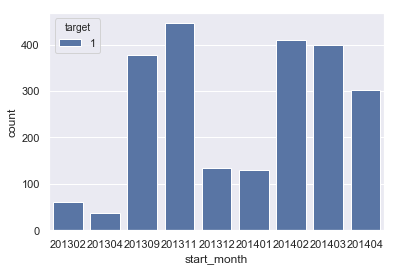

In [46]:
sns.countplot(x='start_month', hue='target', data=X_and_y_train[y_train==1]);

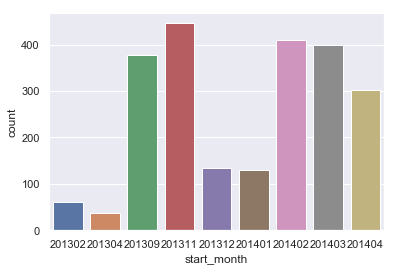

In [47]:
sns.countplot(x='start_month', data=X_and_y_train[y_train==1]);

### Answer(4.6): From the beginning of 2013 to mid-2014, the number of Alice's sessions per month increased

In this way, we have an illustration and thoughts about the usefulness of the new feature, add it to the training sample and check the quality of the new model:

In [48]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [49]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196986151568289


### 4.7. Add to the training set a new feature "n_unique_sites" – the number of the unique web-sites in a session. Calculate how the quality on the validation set has changed

In [50]:
# Read the training and test data sets, change paths if needed
train_df1 = pd.read_csv('../data/Catch Me If You Can/train_sessions.csv',
                       index_col='session_id')
test_df1 = pd.read_csv('../data/Catch Me If You Can/test_sessions.csv',
                      index_col='session_id')

# Convert time1, ..., time10 columns to datetime type
times1 = ['time%s' % i for i in range(1, 11)]
train_df1[times1] = train_df1[times1].apply(pd.to_datetime)
test_df1[times1] = test_df1[times1].apply(pd.to_datetime)

# Sort the data by time
train_df1 = train_df1.sort_values(by='time1')

# Look at the first rows of the training set
#train_df1.head()

In [51]:
# Our target variable
y_train1 = train_df['target']

# United dataframe of the initial data 
full_df1 = pd.concat([train_df1.drop('target', axis=1), test_df1])

# Index to split the training and test data sets
idx_split1 = train_df1.shape[0]

In [52]:
N_U_SXWQZ = full_new_feat['n_unique_sites'] = full_df1[sites].T.nunique(dropna=True).astype('float64')

In [53]:
#Сайты, месяц с маштабированием, число уникальных сайтов в сессии без масштабирования
N_U_SX3 = N_U_SXWQZ.values.reshape(-1,1)
X_train9 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], N_U_SX3[:idx_split,:]]))
print(get_auc_lr_valid(X_train9, y_train))

0.9167809430990923


In [54]:
#Сайты, месяц с маштабированием, число уникальных сайтов в сессии c масштабированием
N_U_SX4 = StandardScaler().fit_transform(pd.DataFrame(N_U_SXWQZ))
X_train20 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], N_U_SX4[:idx_split,:]]))
print(get_auc_lr_valid(X_train20, y_train))

0.9161757459820588


### Answer(4.7): It has decreased. It is better not to add a new feature. 

### 4.8. Add two new features: start_hour and morning. Calculate the metric. Which of these features gives an improvement?

In [55]:
full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour).astype('float64')

In [56]:
full_new_feat['start_hour'].unique()

array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23.,  7.])

In [57]:
full_new_feat['morning'] = (full_new_feat['start_hour'] <= 11).astype('float64')

In [59]:
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301.0,2.0,8.0,1.0
54843,201301.0,2.0,8.0,1.0
77292,201301.0,6.0,8.0,1.0
114021,201301.0,5.0,8.0,1.0
146670,201301.0,6.0,8.0,1.0


In [60]:
# Добавил к sites, start_month, morning без масштаба
morning1 = full_new_feat['morning'].values.reshape(-1,1)
X_train18 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:],\
                              morning1[:idx_split,:]]))
print(get_auc_lr_valid(X_train18, y_train))

0.948667011458439


In [61]:
# Добавил к sites, start_month,morning с масштабом
morning = StandardScaler().fit_transform(full_new_feat[['morning']])
X_train19 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:],\
                              morning[:idx_split,:]]))
print(get_auc_lr_valid(X_train19, y_train))

0.9487757023849204


In [62]:
# Добавил к sites, start_month, start_hour без масштабирования
start_hour1 = full_new_feat['start_hour'].values.reshape(-1,1)
X_train5 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour1[:idx_split,:]]))
print(get_auc_lr_valid(X_train5, y_train))

0.9572750309165303


In [63]:
# Добавил к sites, start_month, start_hour с масштабированием
start_hour = StandardScaler().fit_transform(full_new_feat[['start_hour']])
X_train4 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour[:idx_split,:]]))
print(get_auc_lr_valid(X_train4, y_train))

0.9579252140003575


In [64]:
# Добавил к sites, start_month, start_hour без масштабирования + morning с масштабом
morning = StandardScaler().fit_transform(full_new_feat[['morning']])
X_train9 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour1[:idx_split,:],\
                              morning[:idx_split,:]]))
print(get_auc_lr_valid(X_train9, y_train))

0.9584120587752223


In [65]:
# Добавил к sites, start_month, start_hour без масштабирования + morning без масштаба
morning1 = full_new_feat['morning'].values.reshape(-1,1)
X_train8 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour1[:idx_split,:],\
                              morning1[:idx_split,:]]))
print(get_auc_lr_valid(X_train8, y_train))

0.958495690404765


In [66]:
# Добавил к sites, start_month, start_hour с масштабированием + morning без масштаба
X_train7 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour[:idx_split,:],\
                              morning1[:idx_split,:]]))
print(get_auc_lr_valid(X_train7, y_train))

0.9591223237878547


In [67]:
# Добавил к sites, start_month, start_hour с масштабированием + morning c масштаба
X_train11 = csr_matrix(hstack([full_sites_sparse[:idx_split,:],\
                              tmp[:idx_split,:], start_hour[:idx_split,:],\
                              morning[:idx_split,:]]))
print(get_auc_lr_valid(X_train11, y_train))

0.9591502513175756


### Answer(4.8): Both features gave an improvement

## 5. Regularization and Parameter Tuning

Calculate the quality on a validation set with a regularization parameter, which is equal to 1 by default:

In [68]:
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301.0,2.0,8.0,1.0
54843,201301.0,2.0,8.0,1.0
77292,201301.0,6.0,8.0,1.0
114021,201301.0,5.0,8.0,1.0
146670,201301.0,6.0,8.0,1.0


In [69]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train13 = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train13, y_train)
print(score_C_1)

0.9591502513175756


We will try to beat this result by optimizing the regularization parameter. We will take a list of possible values of C and calculate the quality metric on the validation set for each of C-values:

In [70]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train13, y_train, C=C))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  8.23s/it]


In [71]:
np.set_printoptions(suppress=True)

In [72]:
Cs.round(2)

array([ 0.  ,  0.  ,  0.01,  0.02,  0.06,  0.17,  0.46,  1.29,  3.59,
       10.  ])

In [73]:
Cs

array([ 0.001     ,  0.00278256,  0.00774264,  0.02154435,  0.05994843,
        0.16681005,  0.46415888,  1.29154967,  3.59381366, 10.        ])

In [74]:
scores

[0.8229644453864324,
 0.8965353710466695,
 0.9390416751204054,
 0.9563605175378849,
 0.960692152877411,
 0.9612125106879411,
 0.9603247171620557,
 0.9586708035640963,
 0.9557578867343932,
 0.9513229950147095]

Plot the graph of the quality metric (AUC-ROC) versus the value of the regularization parameter. The value of quality metric corresponding to the default value of C=1 is represented by a horizontal dotted line:

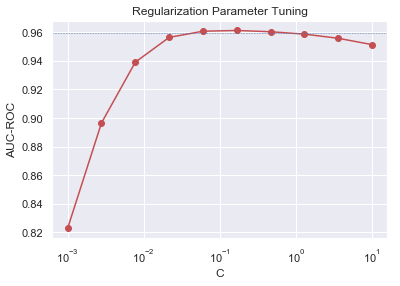

In [75]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

### 4.9. What is the value of parameter C (if rounded to 2 decimals) that corresponds to the highest model quality?

In [76]:
# Capture the quality with C=0.17
score_C_2 = get_auc_lr_valid(X_train13, y_train, C=0.17)
print(score_C_2)

0.9612140202841422


In [77]:
# Capture the quality with C=0.46
score_C_3 = get_auc_lr_valid(X_train13, y_train, C=0.46)
print(score_C_3)

0.9603354352950837


### Answer(4.9): 0.17

For the last task in this assignment: train the model using the optimal regularization parameter you found (do not round up to two digits like in the last question). If you do everything correctly and submit your solution, you should see ROC AUC = 0.92784 on the public leaderboard ("A4 baseline 2"):

In [78]:
# Capture the quality with C=0.16681005
score_C_4 = get_auc_lr_valid(X_train13, y_train, C=0.16681005)
print(score_C_4)

0.9612131145264217


In [79]:
full_new_feat.head()

,start_month,n_unique_sites,start_hour,morning
session_id,,,,
21669,201301.0,2.0,8.0,1.0
54843,201301.0,2.0,8.0,1.0
77292,201301.0,6.0,8.0,1.0
114021,201301.0,5.0,8.0,1.0
146670,201301.0,6.0,8.0,1.0


In [80]:
full_new_feat[['start_month', 'start_hour', 'morning']].head()

,start_month,start_hour,morning
session_id,,,
21669,201301.0,8.0,1.0
54843,201301.0,8.0,1.0
77292,201301.0,8.0,1.0
114021,201301.0,8.0,1.0
146670,201301.0,8.0,1.0


In [81]:
# Prepare the training and test data
tmp_scaled1 = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train14 = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled1[:idx_split,:]]))
X_test14 = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled1[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=0.16681005, random_state=17, solver='liblinear').fit(X_train14, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test14)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_111.csv') #0.92784